In this notebook, we integrate the random walk generated by the *Path integration group* in our simulation. The fly is able to walk around the arena and everytime it gets closer to a source, its memory (implemented via a dictionary) is updated and the fly keeps walking.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
from pathlib import Path
from tqdm import trange
from flygym.mujoco import Parameters
from flygym.mujoco.examples.turning_controller import HybridTurningNMF
from flygym.mujoco.arena import OdorArena

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimesions)
peak_intensity = np.array([[1, 0], [0, 1], [2, 0]])

odor_dimesions = len(peak_intensity[0])

odor_valence = [1, 2, 20]

logging.basicConfig(level=logging.INFO)

In [2]:
# Set up the arena
arena = OdorArena(
    odor_source=odor_source,
    peak_intensity=peak_intensity,
    odor_valence=odor_valence,
    diffuse_func=lambda x: x**-2,
    marker_size=0.3,
)
# Add the NeuroMechFLy

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    simulation_time=10,
    food_loss_rate=0.00003,
    food_stocked_init=1.0,
    mating_state="mated",
)
for i in range(1):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")

In [4]:
# Let's start the simulation
run_time = 8
turns = sim.generate_random_walk(int(run_time / sim.sim_params.timestep))
obs_hist = []
odor_history = []
obs, _ = sim.reset()
for i in trange(int(run_time / sim.sim_params.timestep)):
    action = turns[i]
    obs, reward, terminated, truncated, _ = sim.step(action)
    rendered_img = sim.render()
    obs_hist.append(obs)
    if terminated:
        logging.info("Time for the simulation has elapsed. Simulation is terminated")
        logging.info("Elapsed time in the simulation", sim.curr_time)
        break
    if truncated:
        # the fly is too far away from any source or
        # the fly has been exploring without finding a source for too long
        logging.info("A reward was not found, simulation is truncated")
        logging.info("Elapsed time in the simulation", sim.curr_time)
        break

100%|██████████| 80000/80000 [03:57<00:00, 337.38it/s]


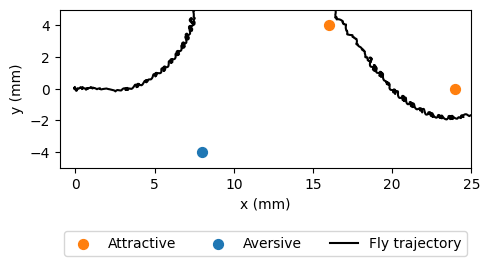

In [5]:
# Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
ax.scatter(
    [odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:orange", s=50
)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 25)
ax.set_ylim(-5, 5)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))

In [6]:
sim.save_video("/home/nmf-learning/flygym-scratch/outputs/random_walk/third_try.mp4")

**IF THE SIMULATION WAS TRUNCATED, WE START AGAIN**

In [ ]:
if truncated:
    _, _ = sim.respawn()
    logging.info("Let's restart")
    turns = sim.generate_random_walk(int(run_time / sim.sim_params.timestep))
    for i in trange(int(run_time / sim.sim_params.timestep)):
        action = turns[i]
        obs, reward, terminated, truncated, _ = sim.step(action)
        rendered_img = sim.render()
        obs_hist.append(obs)
        if terminated:
            logging.info(
                "Time for the simulation has elapsed. Simulation is terminated"
            )
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break
        if truncated:
            # the fly is too far away from any source or
            # the fly has been exploring without finding a source for too long
            logging.info("A reward was not found, simulation is truncated")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break